**Group 007-13 Project Proposal**

**Introduction**

In this project we will be investigating whether the number of rank points a player in a professional tennis match has can be predicted, and what factors are useful in making the prediction. We will do this by running k-nearest neighbour regression using players' height, break point save ratio, and number of double faults. Rank points are used to determine a player's position in the overall global ranking; when they win they gain points and when they lose they lose points. Break points are when a player has the opportunity to win the game on their opponent's serve. Saving a break point is when the serving player is in a break point position and manages to win the game (tennis matches are made up of multiple sets, which consist of multiple games), so a break point save ratio is the ratio of break points saved to break point situations faced. Double faults occur when a player makes two consecutive faults during their serve, and for this their opponent is given a point. A preliminary analysis looking at the relationship between each of these factors independently and rank points indicates possible patterns which will hopefully translate to predictive power in our knn regression.

**Preliminary exploratory data analysis**

In [1]:
# loading data and libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

download.file("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn", "tennis_data.csv")
tennis_data <- read_csv("tennis_data.csv", show_col_types = FALSE) |> select(-...1)
tennis_data

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,NA,⋯,54,34,20,14,10,15,9,3590,16,1977
2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,NA,⋯,52,36,7,10,10,13,16,1977,239,200
2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,NA,⋯,27,15,6,8,1,5,9,3590,40,1050
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,2,104542,NA,NA,⋯,54,30,12,12,5,11,15,2320,76,667
2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,4,105676,NA,NA,⋯,54,44,13,14,7,10,7,3775,15,2320
2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,5,106298,NA,NA,⋯,53,29,11,11,4,11,18,2235,76,667


In [2]:
# prepping, selecting, and splitting relevant data
set.seed(2132)

winner_data <- tennis_data |> select(winner_rank_points, winner_ht, w_df, w_bpSaved, w_bpFaced) |> 
    filter(w_bpSaved != 0) |> filter(w_bpFaced != 0) |> mutate(bpratio = w_bpSaved/w_bpFaced) |> na.omit() |>
    rename(rank_points = winner_rank_points, height = winner_ht, double_faults = w_df) |>
    select(-w_bpSaved, -w_bpFaced)
loser_data <- tennis_data |> select(loser_rank_points, loser_ht, l_df, l_bpSaved, l_bpFaced) |> 
    filter(l_bpSaved != 0) |> filter(l_bpFaced != 0) |> mutate(bpratio = l_bpSaved/l_bpFaced) |> na.omit() |>
    rename(rank_points = loser_rank_points, height = loser_ht, double_faults = l_df) |>
    select(-l_bpSaved, -l_bpFaced)

player_data <- rbind(winner_data, loser_data)

player_split <- initial_split(player_data, prop = .75, strata = rank_points)  
player_train <- training(player_split)
player_test <- testing(player_split)

In [3]:
# expository analysis table

exposit_table <- tibble("player_train_leng" = nrow(player_train), 
                        "rp_avg" = mean(player_train$rank_points),
                       "height_avg" = mean(player_train$height),
                       "df_avg" = mean(player_train$double_faults),
                       "bpratio_avg" = mean(player_train$bpratio))
exposit_table

player_train_leng,rp_avg,height_avg,df_avg,bpratio_avg
<int>,<dbl>,<dbl>,<dbl>,<dbl>
5733,1711.984,186.0911,3.202861,0.6316063


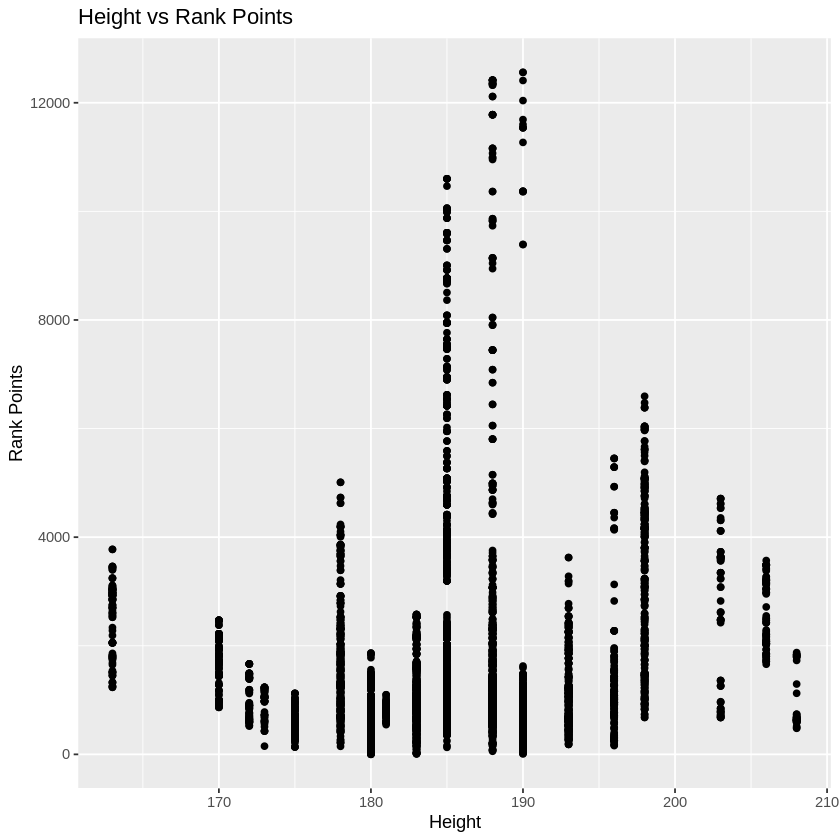

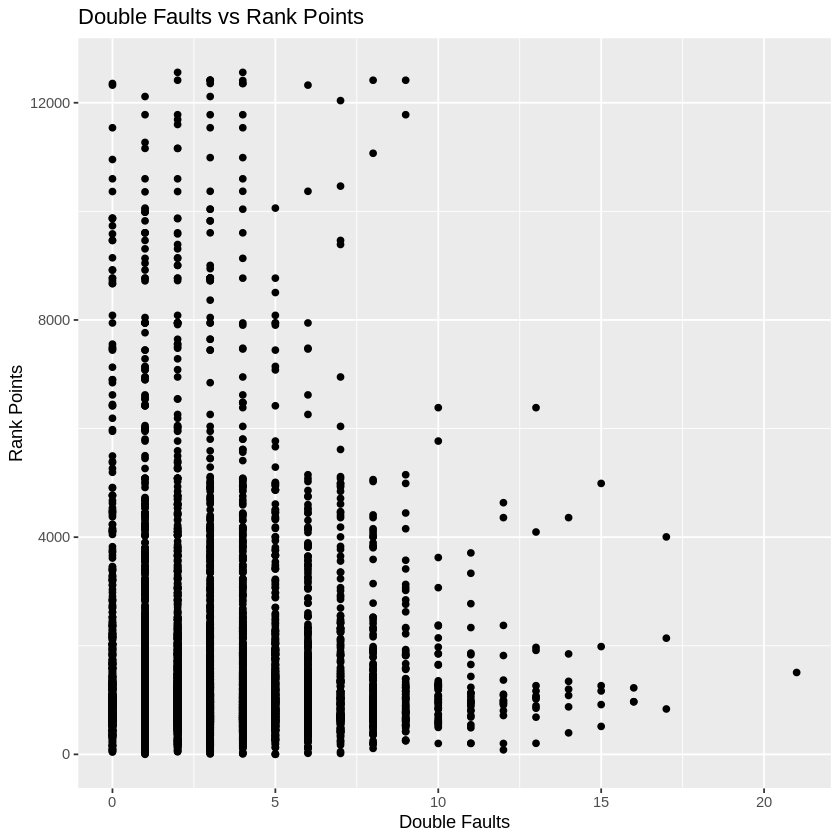

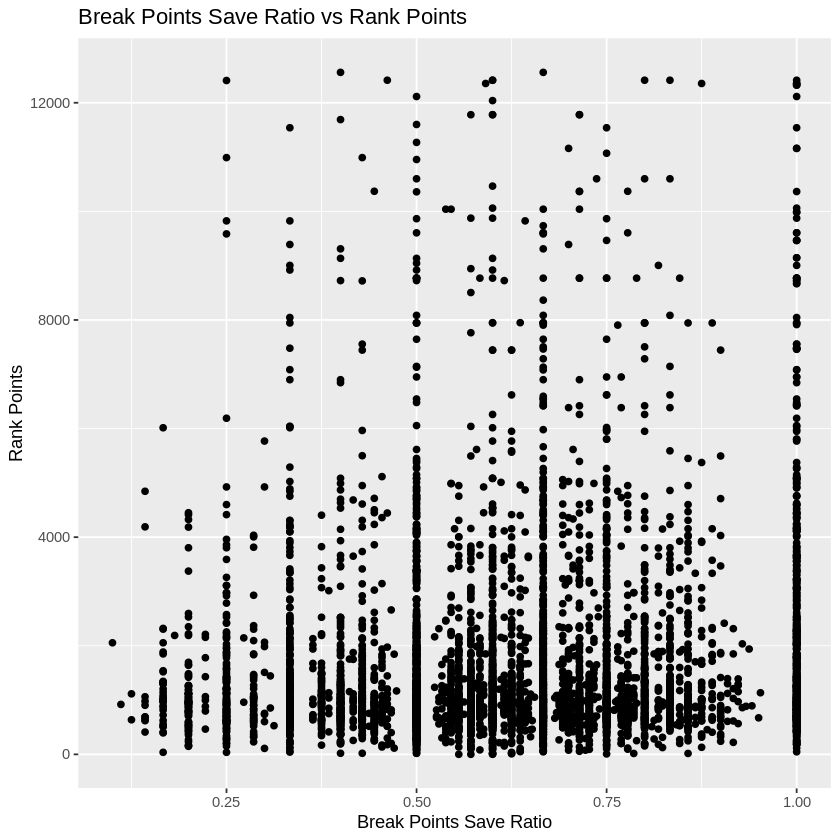

In [4]:
# expository analysis graphs

height_plot <- ggplot(player_train, aes(x = height, y = rank_points)) +
    geom_point() +
    labs(title = "Height vs Rank Points", x = "Height", y = "Rank Points")
height_plot

df_plot <- ggplot(player_train, aes(x = double_faults, y = rank_points)) +
    geom_point() +
    labs(title = "Double Faults vs Rank Points", x = "Double Faults", y = "Rank Points")
df_plot

bpratio_plot <- ggplot(player_train, aes(x = bpratio, y = rank_points)) +
    geom_point() +
    labs(title = "Break Points Save Ratio vs Rank Points", x = "Break Points Save Ratio", y = "Rank Points")
bpratio_plot

**Methods**

Upon initial loading our dataset contained 49 variables, with each row representing a tennis match; the variables which were unrelated to specific players and performance (e.g. Tournament name, playing surface, player's country) were eliminated and graphs were created to plot each other variable against rank points and examined for possible signs of relationships. The following variables were found to be relevant to our analysis: winner's rank points, winner's height, winner's number of double faults, number of break points the winner faced, number of break points the winner saved, loser's rank points, loser's height, loser's number of double faults, number of break points the loser faced, number of break points the loser saved. We combined the data about losers and winners into one datframe with all the players and their match data. With this information our model will hopefully be able to predict a player's rank points. We will visualize our results by graphing the k-nearest neighbour regression predictions for both winners and losers against the testing data.

**Expected outcomes and significance**

Based on our preliminary expository data analysis, we predict that it will be possible to create a model that can roughly predict the rank points of a player from a tennis match based on their height, the number of double faults they commit, and their break point save ratio. These variables all appear to have a relationship as seen in the plots above. Using this prediction model people could have a heightened knowledge set which aids with placing bets, predicting the outcome of new players, and depicting how a tournament may turn out. In the future this can even be improved upon by including more specific and numerous variables, or using a more complex quantifier for playing capability than rank points. The data also hints at a future question that we will not pursue here, but could be interesting; how well can we predict the winner or loser of a tennis match based on their rank points or other relevant data?